In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV



%matplotlib inline

sns.set(rc={'figure.figsize':(20, 6)})

In [2]:
def get_title_from_name(name):
    """
    Returns title (e.g. 'mr') from full name
    """
    return name.split(',')[1].split('.')[0].strip()


def compact_title(row):
    """
    Converts any title to: mr / mrs / ms / master / other
    """
    title = row[TITLE].lower()
    gender = row[GENDER].lower()
    if title in ['don', 'rev', 'major', 'sir', 'col', 'capt', 'jonkheer', 'mr']:
        return 'mr'
    if title in ['mme', 'the countess', 'lady', 'mrs', 'dona']:
        return 'mrs'
    if title in ['miss', 'mlle', 'ms']:
        return 'ms'
    if title == 'dr':
        if gender == 'male':
            return 'mr'
        else:
            return 'mrs'
    if title == 'master':
        return 'master'
    return 'Other'


def extract_cabin_letter(cabin):
    """
    Extracts cabin letter (deck) from full cabin name
    """
    return 'Unknown' if pd.isnull(cabin) else cabin[0]

def draw_hist(series):
    """
    Draw histogram from given series
    """
    plt.hist(series)
    plt.title(series.name)
    plt.show()

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
# load the training data
training = pd.read_csv('/kaggle/input/titanic/train.csv')
print(f'Training size: {training.shape[0]}')
training.head()

Training size: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# load the test data
test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(f'Test size: {test.shape[0]}')
test.head()

Test size: 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
training.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Coleff, Mr. Peju",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Becker, Miss. Ruth Elizabeth",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [8]:
# globals

PID = 'PassengerId'
PCLASS,NAME,GENDER,AGE,SIBLINGS,PARENTS,TICKET,FARE,CABIN,EMBARKED='Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'
SEX = GENDER
DECK,TITLE = 'Deck','Title'
TICKET_PREFIX = 'Ticket Prefix'
FAMILY_SIZE = 'Family Size'
# FARE_PER_PERSON = 'FarePerPerson'
# TOTAL_FAM_FARE = 'TotalFamilyFare'

SURVIVED = LABEL = 'Survived'

In [9]:
print('Nans:')
training.isna().sum()

Nans:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# Embarked Nans are just a few. Drop`em
training = training.dropna(subset=[EMBARKED]).reset_index(drop=True)
training.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [11]:
# combine training and test for easier work
alldata = training.append(test).reset_index(drop=True)
alldata.fillna(np.NaN, inplace=True)
print(f'All data size: {alldata.shape[0]}')
alldata.head()

All data size: 1307


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
print('Nans:')
alldata.isna().sum()

Nans:


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
dtype: int64

In [13]:
# 1 Nan FARE, fill it with mean (33) or median (14)

#alldata[FARE].describe()
alldata[FARE] = alldata[FARE].fillna(alldata[FARE].dropna().median())

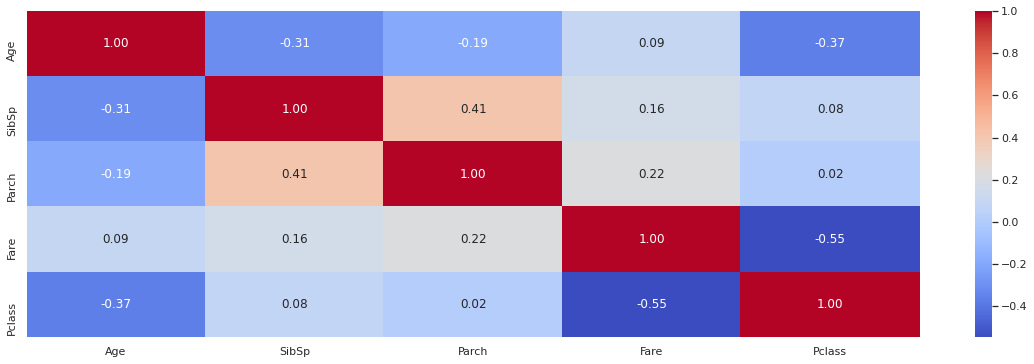

In [14]:
# we have to predict the AGE for the missing entries
# we can use knn to impute the data, but first we better find the features the correlate the best with the AGE
g = sns.heatmap(training[[AGE, SIBLINGS, PARENTS, FARE, PCLASS]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
# conclusion: all of them are quite informative except fare

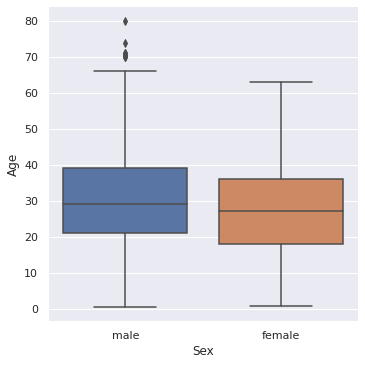

In [15]:
# see if gender is correlated with age
g = sns.catplot(y=AGE, x=GENDER, data=training, kind='box')
# conclusion: slightly, so don't use it for imputation

In [16]:
# impute age using PARENTS, SIBLINGS, PCLASS
imputer = KNNImputer(n_neighbors=10)  # TODO: Try different neighbors number
imputed_data = imputer.fit_transform(alldata[[PARENTS, SIBLINGS, PCLASS, AGE]])
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = [PARENTS, SIBLINGS, PCLASS, AGE]
alldata[AGE] = df_temp[AGE]
alldata.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

In [17]:
# explore cat features
for col in [PCLASS, GENDER, EMBARKED, CABIN]:
    print(alldata[col].value_counts())
    print('')

# conculsions: cabins have to be grouped.
# the Nans in cabins will all be grouped together

3    709
1    321
2    277
Name: Pclass, dtype: int64

male      843
female    464
Name: Sex, dtype: int64

S    914
C    270
Q    123
Name: Embarked, dtype: int64

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C22 C26            4
F4                 4
                  ..
A5                 1
E63                1
D48                1
B38                1
B36                1
Name: Cabin, Length: 185, dtype: int64



In [18]:
#create new column DECK, which groups up the cabins
#all empty cabins will be grouped together as a separate group
temp = alldata[CABIN].apply(extract_cabin_letter)
print(temp.value_counts())
alldata[DECK] = temp

#drop the cabin column, we don't need it anymore
alldata.drop([CABIN], axis=1, inplace=True)

Unknown    1014
C            94
B            63
D            46
E            41
A            22
F            21
G             5
T             1
Name: Cabin, dtype: int64


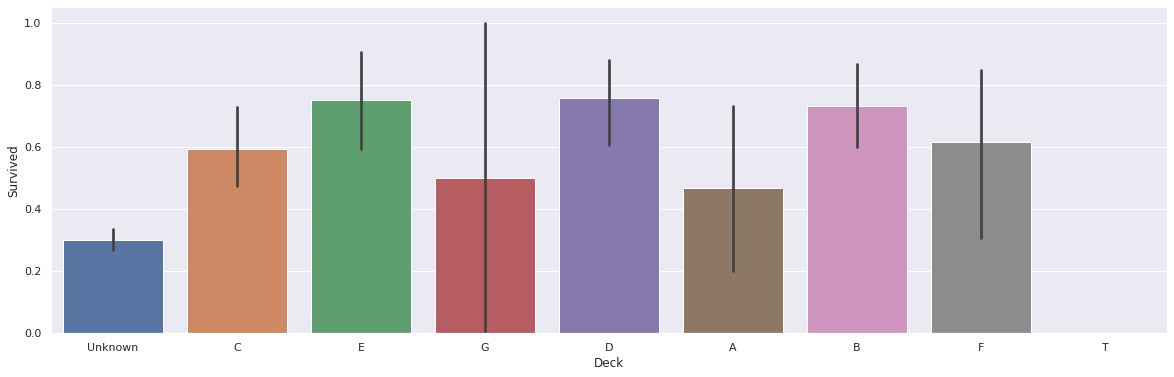

In [19]:
# visualize deck against survival
g = sns.barplot(x=DECK, y=LABEL, data=alldata[:training.shape[0]])

#conclusion: Unknown, G, A have a low chance of survival

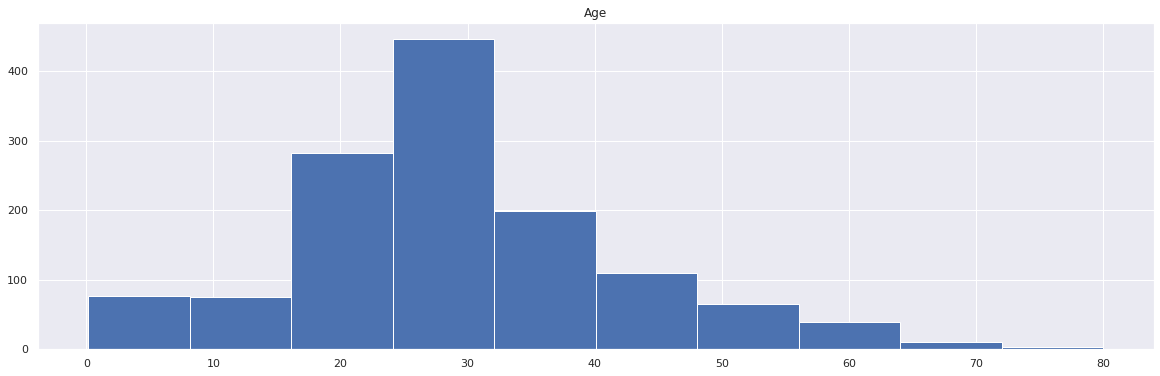

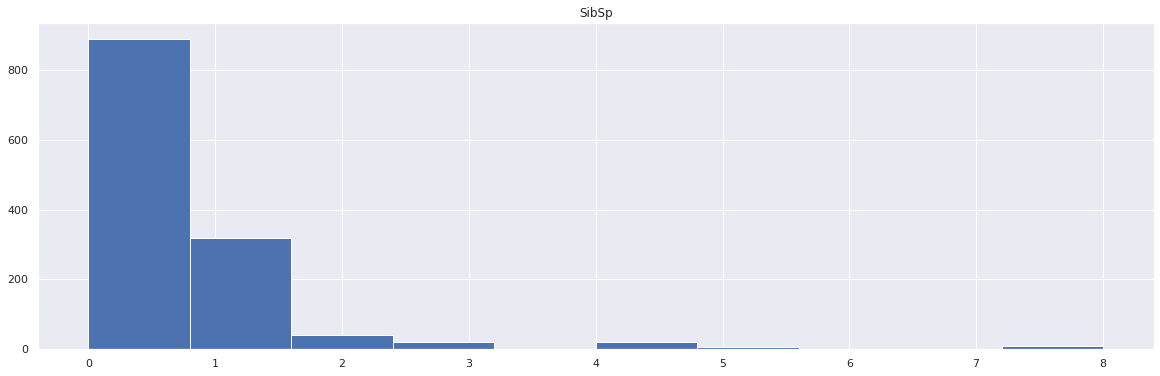

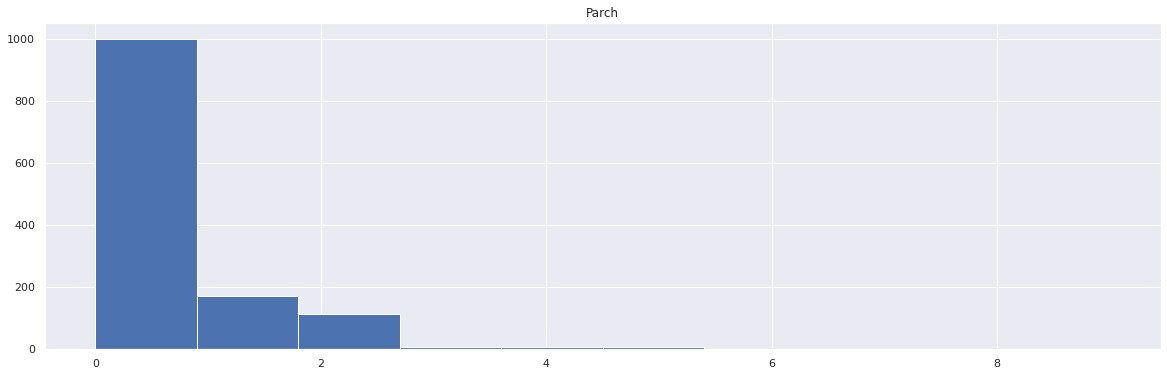

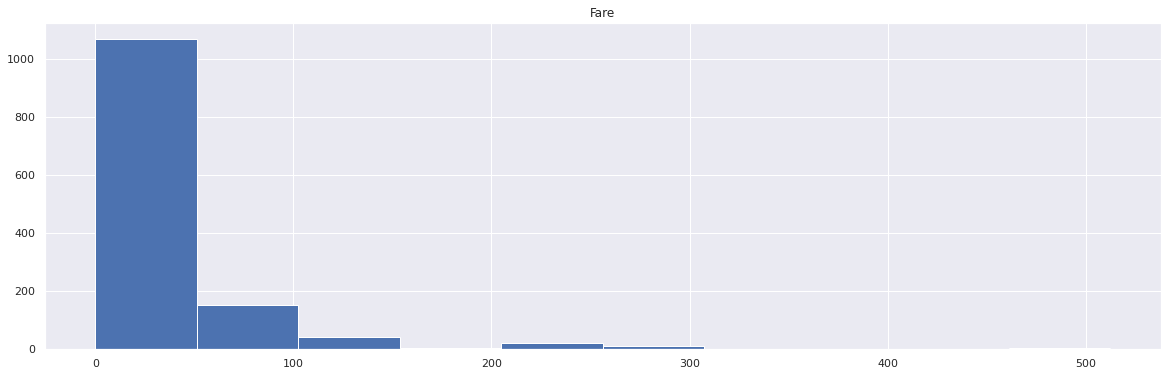

In [20]:
#explore the numeric data

# histograms to visualize distribution of numeric features
visualize_cols = [AGE, SIBLINGS, PARENTS, FARE]
for col in visualize_cols:
    draw_hist(alldata[col])

# conclusions: SIBLINGS, PARENTS, FARE need to be logged / normalized.

In [21]:
# add the family size feature here (thought about it too late)
alldata[FAMILY_SIZE] = alldata[SIBLINGS] + alldata[PARENTS] + 1  # 1 is the person themselves

# save it for later visualization
fam_size_backup_df = pd.DataFrame()
fam_size_backup_df[FAMILY_SIZE] = alldata[FAMILY_SIZE].copy()
fam_size_backup_df[LABEL] = alldata[LABEL]

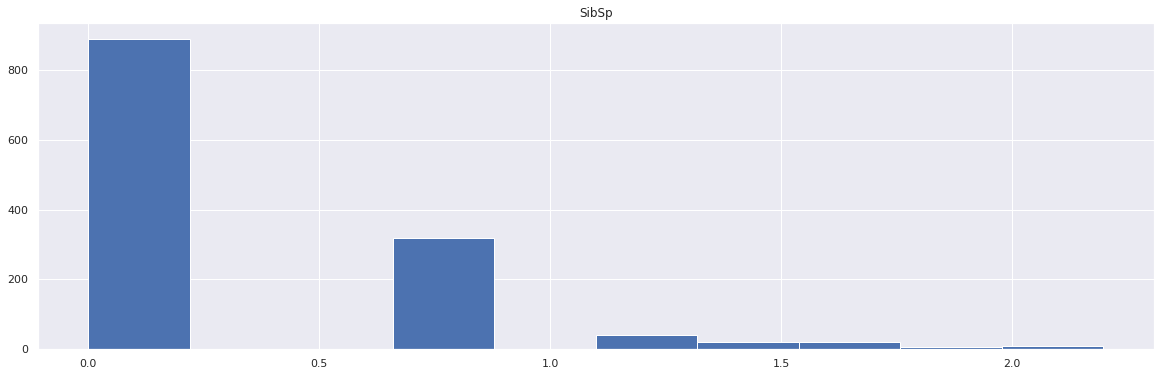

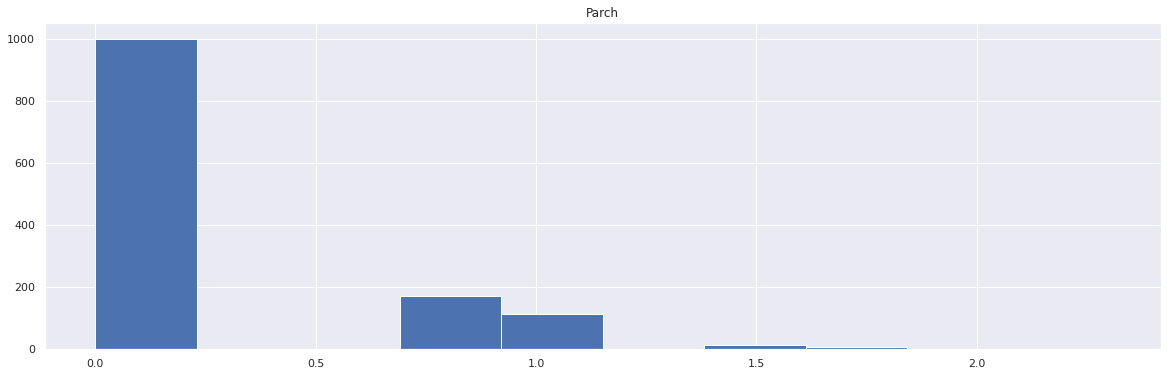

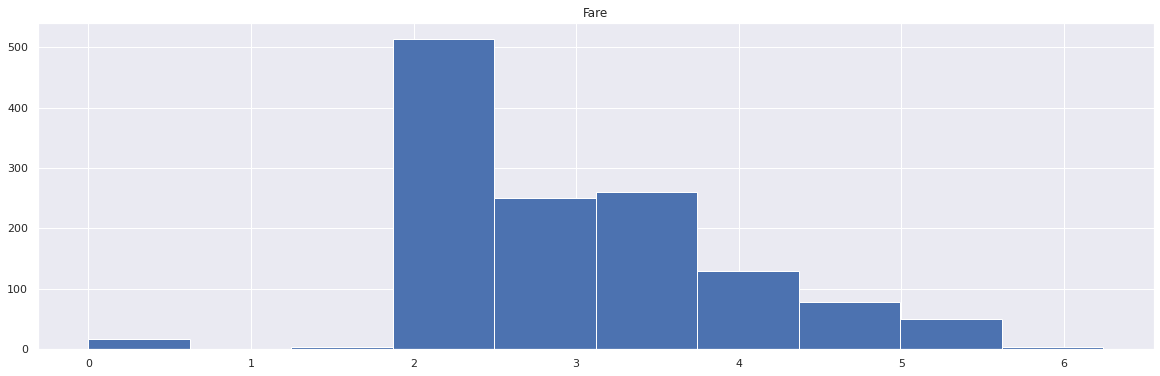

In [22]:
# transform skewed features to log
# now transform
for col in [SIBLINGS, PARENTS, FARE]:
    temp = np.log(alldata[col] + 1)
    draw_hist(temp)
    alldata[col] = temp

In [23]:
#explore the rest of the features (NAME, TICKET)

alldata[[NAME, TICKET]].head()

#conclusions: NAME has a title! (Mr. / Miss. / ...)

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450


In [24]:
#extract the title, and group common titles together.
#first let's see how many titles there are
titles = alldata[NAME].apply(get_title_from_name)
print(f'Unique title values: {titles.nunique()}')
titles.value_counts()

Unique title values: 18


Mr              757
Miss            259
Mrs             196
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Don               1
Mme               1
Sir               1
Capt              1
Lady              1
Dona              1
Jonkheer          1
the Countess      1
Name: Name, dtype: int64

In [25]:
# add the title feature
alldata[TITLE] = titles

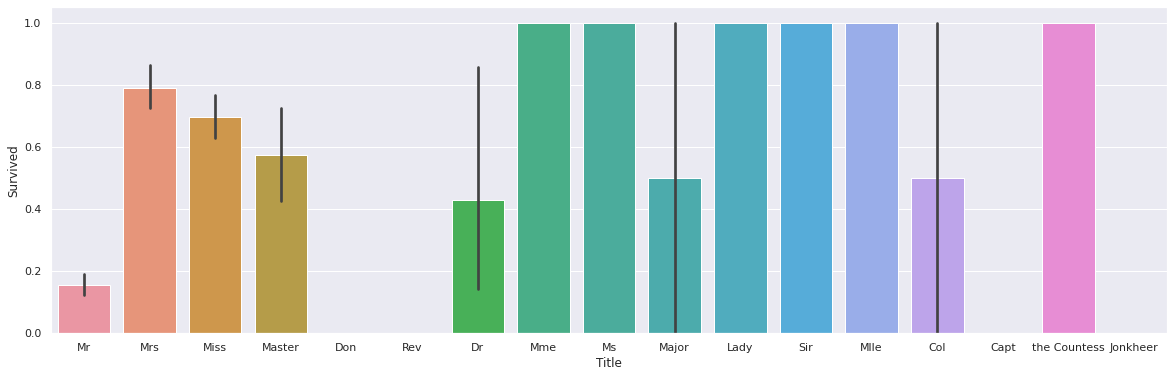

In [26]:
# we already have the gender feature, so [Mr vs. Mrss & Miss] is already covered. but let's draw a bars graph against SURVIVAL

g = sns.barplot(x=TITLE, y=LABEL, data=alldata[:training.shape[0]])

# conclusion: Mr (males) have low chance of survival, and females (Mrs. / Miss) have a high chance of survival (women and children first).
# also Mrs. and Miss have different percentages, so we'll separate those too.
# but it's not clear what "Master" means. Its chance of survival differs from the other major groups, so we should make it a separate group by itself.
# the other titles are not informative since they are very small (e.g. 'the Countess' we have only 1).
# so we will group everything to 4 major titles: Mr / Mrs. / Miss / Master

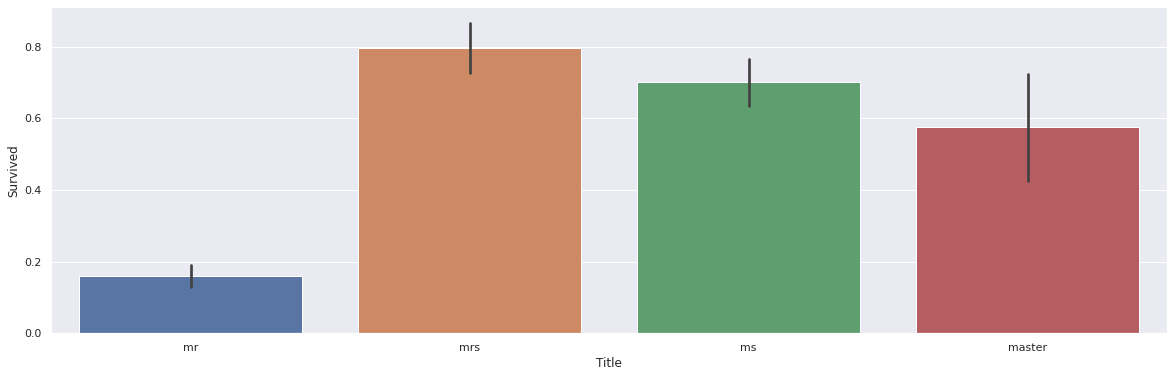

In [27]:
# compact title column
alldata[TITLE] = alldata.apply(compact_title, axis=1)
g = sns.barplot(x=TITLE, y=LABEL, data=alldata[:training.shape[0]])
# TODO: Try the following groups instead: Mr / Mrs & Ms / Other

In [28]:
#explore the ticket column
#print(f'Unique ticket values: {alldata[TICKET].nunique()}/{alldata.shape[0]}')
#alldata[TICKET].value_counts()
sorted(alldata[TICKET])
#alldata[TICKET].head(n=20)

['110152',
 '110152',
 '110152',
 '110413',
 '110413',
 '110413',
 '110465',
 '110465',
 '110469',
 '110489',
 '110564',
 '110813',
 '110813',
 '111163',
 '111240',
 '111320',
 '111361',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112051',
 '112052',
 '112053',
 '112058',
 '112058',
 '112059',
 '112277',
 '112377',
 '112378',
 '112378',
 '112379',
 '112901',
 '113028',
 '113038',
 '113043',
 '113044',
 '113050',
 '113051',
 '113054',
 '113055',
 '113056',
 '113059',
 '113059',
 '113501',
 '113503',
 '113503',
 '113503',
 '113503',
 '113503',
 '113505',
 '113505',
 '113509',
 '113509',
 '113510',
 '113514',
 '113760',
 '113760',
 '113760',
 '113760',
 '113767',
 '113773',
 '113773',
 '113776',
 '113776',
 '113778',
 '113780',
 '113781',
 '113781',
 '113781',
 '113781',
 '113781',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113789',
 '113790',
 '113791',
 '113792',
 '113794',
 '113795',
 '113796',
 '113796',
 '113798',
 '113798',

In [29]:
#try to group by prefix (up to 2 first chars)
ticket_prefix = alldata[TICKET].apply(lambda ticket: ticket.split()[0][:1])  # currently 1 char. TODO: Try 2
ticket_prefix.unique()

array(['A', 'P', 'S', '1', '3', '2', 'C', '7', 'W', '4', 'F', 'L', '9',
       '6', '5', '8'], dtype=object)

3    429
2    278
1    208
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64


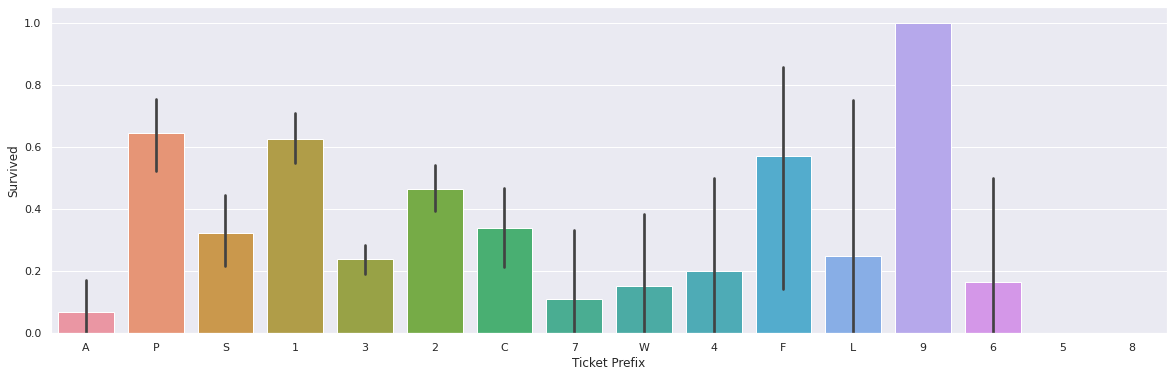

In [30]:
# see if there's any correlation with SURVIVAL
print(ticket_prefix.value_counts())
temp_df = pd.DataFrame()
temp_df[TICKET_PREFIX] = ticket_prefix
temp_df['TicketPrefixCount'] = ticket_prefix.apply(lambda ticket: ticket_prefix[ticket_prefix == ticket].shape[0])
temp_df[LABEL] = alldata[LABEL]
temp_df.dropna(inplace=True)  # drop the test rows...
g = sns.barplot(x=TICKET_PREFIX, y=LABEL, data=temp_df)

# conclusion: there's some correlation. some letters survive significantly less than others.

In [31]:
#add the ticket prefix column, and drop the ticker column
alldata[TICKET_PREFIX] = ticket_prefix
alldata.drop([TICKET], axis=1, inplace=True)

In [32]:
# add more features

# family size
alldata[FAMILY_SIZE] = alldata[SIBLINGS] + alldata[PARENTS] + 1  # 1 is the person themselves

# fare per person
# extract family name
#surname = alldata[NAME].apply(lambda full_name: full_name.split()[0])
#alldata[TOTAL_FAM_FARE] = alldata.apply(lambda row: alldata.loc[(alldata[NAME].str.len() > 0) & (alldata[NAME].str.split().str[0] == row[NAME].split()[0]), FARE].sum() , axis=1)
#TURNS OUT ALL FAM MEMBERS HAVE EXACT SAME FARE! SO NO POINT IN TAKING AVG PER FAM MEMBER

# drop name column, we don't need it anymore
alldata.drop([NAME], axis=1, inplace=True)

In [33]:
# drop the id column, we don't need it
alldata.drop([PID], axis=1, inplace=True)

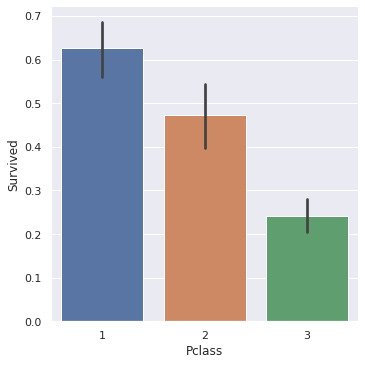

In [34]:
# let's visualize how each feature correlates with the SURVIVAL label independently, just to get a taste

# PCLASS
g = sns.catplot(x=PCLASS, y=LABEL, data=alldata.iloc[:training.shape[0]], kind='bar')

# conclusion: the lower the class, the higher the survival. so that's a good feature.
# we saw previously that class 3 belongs mostly to older people, which means 1 and 2 belong mostly to younger people,
# which have higher survival chance ("women and children first")

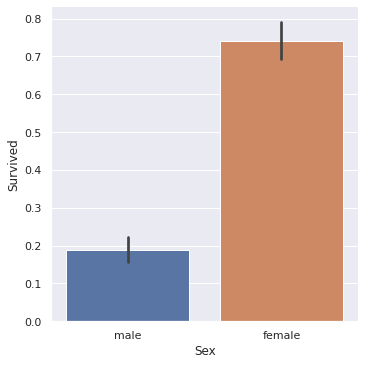

In [35]:
# GENDER
g = sns.catplot(x=GENDER, y=LABEL, data=alldata.iloc[:training.shape[0]], kind='bar')

#conclusion: gender is very indicative. "Women and children first"

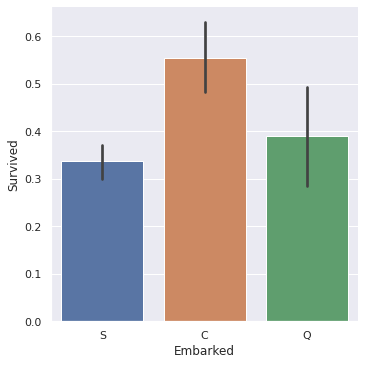

In [36]:
# EMBARKED
g = sns.catplot(x=EMBARKED, y=LABEL, data=alldata.iloc[:training.shape[0]], kind='bar')

# conclusion: S has low survival rate

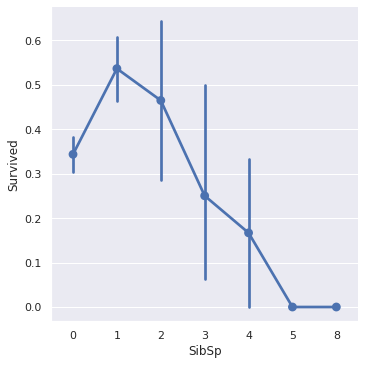

In [37]:
# SIBLINGS
g = sns.catplot(x=SIBLINGS, y=LABEL, data=training, kind='point')

#conclusion: 0 or >=3 siblings have low chance of survival

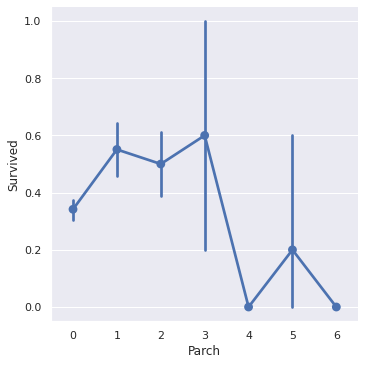

In [38]:
# PARENTS
g = sns.catplot(x=PARENTS, y=LABEL, data=training, kind='point')

#conclusion: 0 or >=4 parents have low chance of survival

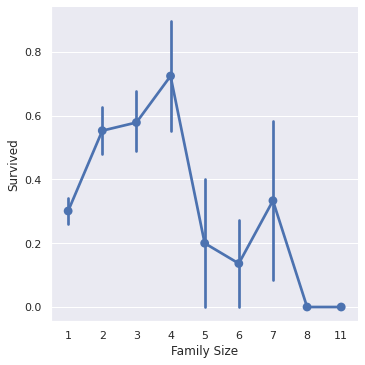

In [39]:
# FAM SIZE (saved it earlier)
g = sns.catplot(x=FAMILY_SIZE, y=LABEL, data=(fam_size_backup_df.iloc[:training.shape[0]]), kind='point')

# conclusion: fam size 1 and >=5 have low chance of survival, fam size 4 have a significantly higher chance

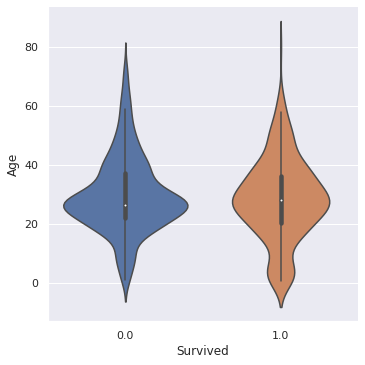

In [40]:
# AGE
g = sns.catplot(x=LABEL, y=AGE, data=alldata.iloc[:training.shape[0]], kind='violin')

# conclusion: most children survived. "women and children first"
# and most of mid age (~30) didn't survive

In [41]:
# AGE
young = training.loc[training[AGE] <= 13, [AGE, LABEL]]
midage = training.loc[(20 <= training[AGE]) & (training[AGE] <= 30), [AGE, LABEL]]
old = training.loc[training[AGE] > 13, [AGE, LABEL]]
print(f'Ratio of children who survived: {young.loc[young[LABEL] == 1, LABEL].sum() / young.shape[0]}')
print(f'Ratio of adults who survived: {old.loc[old[LABEL] == 1, LABEL].sum() / old.shape[0]}')
print(f'Ratio of mid age who survived: {midage.loc[midage[LABEL] == 1, LABEL].sum() / midage.shape[0]}')

Ratio of children who survived: 0.5915492957746479
Ratio of adults who survived: 0.3837753510140406
Ratio of mid age who survived: 0.3551020408163265


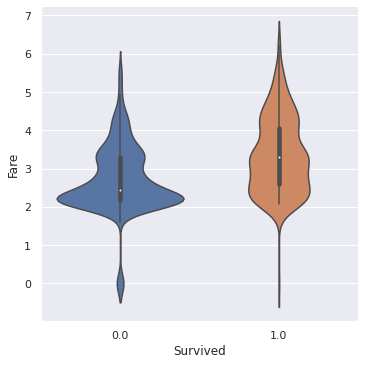

In [42]:
# FARE
g = sns.catplot(x=LABEL, y=FARE, data=alldata.iloc[:training.shape[0]], kind='violin')

# conclusion: most low fare didn't survive

In [43]:
# FARE
temp = alldata.iloc[:training.shape[0]].copy()
low_fare = temp.loc[temp[FARE] < 3, [FARE, LABEL]]
high_fare = temp.loc[temp[FARE] >= 3, [FARE, LABEL]]
print(f'Ratio of low fare who survived: {low_fare.loc[low_fare[LABEL] == 1, LABEL].sum() / low_fare.shape[0]}')
print(f'Ratio of high fare who survived: {high_fare.loc[high_fare[LABEL] == 1, LABEL].sum() / high_fare.shape[0]}')


Ratio of low fare who survived: 0.2702169625246548
Ratio of high fare who survived: 0.5314136125654451


In [44]:
# Prepare data for prediction

y_train = alldata.iloc[:training.shape[0]][LABEL].astype(int)

features = [PCLASS, TITLE, GENDER, AGE, SIBLINGS, PARENTS, FAMILY_SIZE, TICKET_PREFIX, FARE, DECK, EMBARKED]
alldata = pd.get_dummies(alldata[features])

X_train = alldata.iloc[:training.shape[0]]
X_test = alldata.iloc[training.shape[0]:]

In [45]:
# Classifiers

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
svm = SVC(probability = True)
knn = KNeighborsClassifier()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
xgb_train_X, xgb_val_X, xgb_train_y, xgb_val_y = train_test_split(X_train, y_train, random_state=1)
#xgb = XGBClassifier(n_estimators=500, use_label_encoder=False)
#xgb.fit(xgb_train_X, xgb_train_y, early_stopping_rounds=5, eval_set=[(xgb_val_X, xgb_val_y)], verbose=True)  # => stops after 20 iterations
#print('XGBClassifier')
#print(accuracy_score(xgb_val_y, xgb.predict(xgb_val_X)))
#print('')
xgb = XGBClassifier(n_estimators=20, use_label_encoder=False)

clfs = [rf, svm, knn, xgb]
for clf in clfs:
    print(clf.__class__.__name__)
    cv = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Cross validation scores: {cv}')
    print(f'Cross validation avg score: {cv.mean()}')
    print('')

RandomForestClassifier
Cross validation scores: [0.83146067 0.8258427  0.8258427  0.7752809  0.85310734]
Cross validation avg score: 0.8223068621849807

SVC
Cross validation scores: [0.67977528 0.75842697 0.71910112 0.73595506 0.76271186]
Cross validation avg score: 0.7311940582746143

KNeighborsClassifier
Cross validation scores: [0.74719101 0.79213483 0.7752809  0.79775281 0.83050847]
Cross validation avg score: 0.7885736050276138

XGBClassifier
[11:39:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:27] WARNING: ../src/learner.cc:1061: 

In [46]:
# Parameter tuning

In [47]:
# RF tuning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_features": ['auto', 'log2', None],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "n_estimators" :[10, 100, 200]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=4)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

0.836926299752428

In [48]:
clfs.append(RFC_best)

In [49]:
# fit on all the data
for clf in clfs:
    clf.fit(X_train, y_train)

[11:40:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

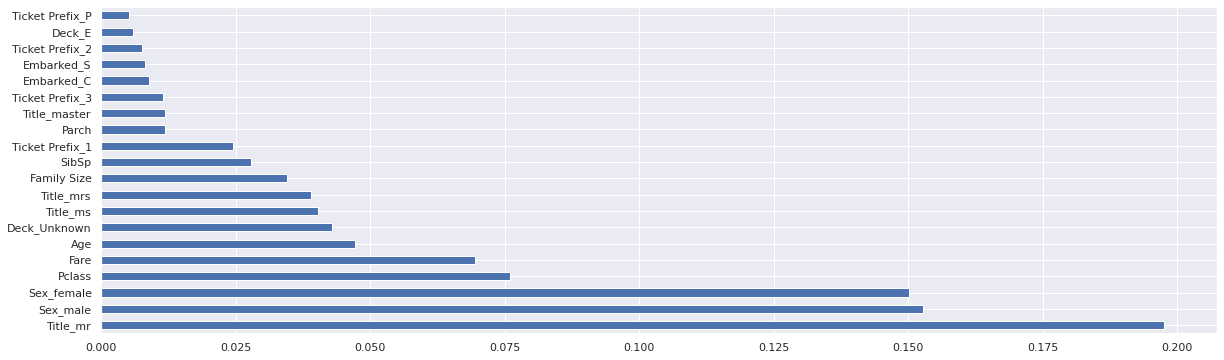

In [50]:
# visualize best features (RF only)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [51]:
# ensemble
voting_clf = VotingClassifier(estimators = [('knn',knn),('rf',rf), ('svm',svm)], voting = 'soft') 
cv = cross_val_score(voting_clf, X_train, y_train, cv=5)
voting_clf.fit(X_train, y_train)
print('Ensemble:')
print(cv)
print(cv.mean())

Ensemble:
[0.78089888 0.81460674 0.81460674 0.79775281 0.85875706]
0.8133244461372436


In [52]:
# generate predictions
# predictions = voting_clf.predict(X_test)  # ==> RESULTS ON TEST: 0.76076
predictions = rf.predict(X_test)  # ==> RESULTS ON TEST: 0.78468
#predictions = RFC_best.predict(X_test)  # ==> RESULTS ON TEST: 0.78229
output = pd.DataFrame({PID: test[PID], LABEL: predictions})
output.to_csv('my_submission.csv', index=False)
print('Submission saved')

Submission saved
